In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据
df = pd.read_csv(r'E:\miniconda\ChineseSuperLeague\data\features.csv')
X = df[['home_last3_goals', 'away_last3_concede', 'home_last2_loss']].values
y = (df['result'] == 'H').astype(int).values

# 2. 分层 + 标准化
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. 转 Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)
print(1)

1


In [5]:
class MLP_REG(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP_REG()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(1)

1


In [6]:
epochs = 300
train_losses, val_losses = [], []
best_val_loss = np.inf
patience, counter = 20, 0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # 验证 loss
    model.eval()
    with torch.no_grad():
        val_out = model(X_test)
        val_loss = criterion(val_out, y_test).item()
    val_losses.append(val_loss)

    # 早停
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'mlp_reg_best.pth')
    else:
        counter += 1
    if counter >= patience:
        print(f'早停于 epoch {epoch+1}')
        break

    if (epoch+1) % 50 == 0:
        print(f'Epoch {epoch+1:3d} | Train Loss = {loss.item():.4f} | Val Loss = {val_loss:.4f}')

早停于 epoch 39


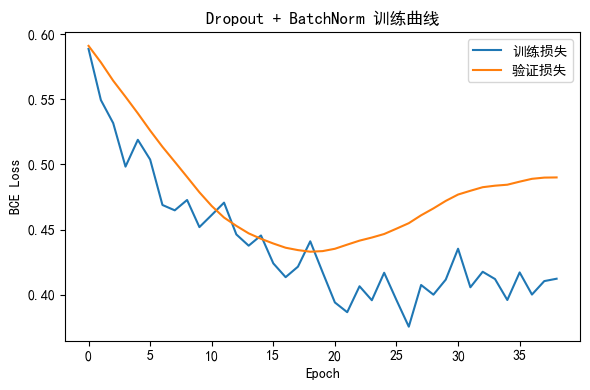

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='训练损失')
plt.plot(val_losses, label='验证损失')
plt.title('Dropout + BatchNorm 训练曲线')
plt.xlabel('Epoch'); plt.ylabel('BCE Loss')
plt.legend(); plt.tight_layout(); plt.show()

In [8]:
model.load_state_dict(torch.load('mlp_reg_best.pth'))
model.eval()
with torch.no_grad():
    logits = model(X_test)
    probs = torch.sigmoid(logits).numpy().squeeze(-1)

# 阈值扫频
from sklearn.metrics import precision_recall_curve, f1_score
prec, rec, ths = precision_recall_curve(y_test, probs)
f1s = 2 * prec * rec / (prec + rec)
best_th = ths[np.argmax(f1s)]
print(f'最佳阈值={best_th:.2f} | 最大F1={f1s[np.argmax(f1s)]:.2f}')

y_pred = (probs >= best_th).astype(int)
print('\n'+classification_report(y_test, y_pred, target_names=['非主胜', '主胜']))

最佳阈值=0.36 | 最大F1=0.50

              precision    recall  f1-score   support

         非主胜       0.93      0.87      0.90        30
          主胜       0.43      0.60      0.50         5

    accuracy                           0.83        35
   macro avg       0.68      0.73      0.70        35
weighted avg       0.86      0.83      0.84        35

